# Data Pre-Processing

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
from PIL import Image

# Define transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/validation', transform=val_test_transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/test', transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

# Example usage: Load a batch of training data
for images, labels in train_loader:
    print(f'Image batch shape: {images.size()}')
    print(f'Label batch shape: {labels.size()}')
    break


Training dataset size: 1920
Validation dataset size: 480
Test dataset size: 600
Image batch shape: torch.Size([32, 1, 128, 128])
Label batch shape: torch.Size([32])


# CNN Model-1

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the CNN model
class VenueCNN(nn.Module):
    def __init__(self):
        super(VenueCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 1 input channel for grayscale
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 5)  # Assuming 5 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create model instance
model = VenueCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = torch.max(outputs, 1)[1]
                corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = corrects.double() / len(val_loader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return model

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            y_true.extend(labels.numpy())
            y_pred.extend(preds.numpy())
    print(classification_report(y_true, y_pred))

# Train and evaluate the model
model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25)
torch.save(model.state_dict(), 'venue_cnn.pth')

# Load the saved model
model.load_state_dict(torch.load('venue_cnn.pth'))
evaluate_model(model, test_loader)


Epoch 0/24, Loss: 1.5721, Val Loss: 1.3286, Val Acc: 0.3958
Epoch 1/24, Loss: 1.3213, Val Loss: 1.2795, Val Acc: 0.4313
Epoch 2/24, Loss: 1.2874, Val Loss: 1.2516, Val Acc: 0.4646
Epoch 3/24, Loss: 1.2381, Val Loss: 1.2755, Val Acc: 0.4396
Epoch 4/24, Loss: 1.2162, Val Loss: 1.2347, Val Acc: 0.4375
Epoch 5/24, Loss: 1.1792, Val Loss: 1.2531, Val Acc: 0.4417
Epoch 6/24, Loss: 1.1638, Val Loss: 1.2252, Val Acc: 0.4771
Epoch 7/24, Loss: 1.1122, Val Loss: 1.1932, Val Acc: 0.4688
Epoch 8/24, Loss: 1.0745, Val Loss: 1.1786, Val Acc: 0.5271
Epoch 9/24, Loss: 1.0126, Val Loss: 1.1897, Val Acc: 0.4896
Epoch 10/24, Loss: 0.9926, Val Loss: 1.1972, Val Acc: 0.5062
Epoch 11/24, Loss: 0.9721, Val Loss: 1.1783, Val Acc: 0.5208
Epoch 12/24, Loss: 0.9308, Val Loss: 1.1511, Val Acc: 0.5292
Epoch 13/24, Loss: 0.8761, Val Loss: 1.2000, Val Acc: 0.5188
Epoch 14/24, Loss: 0.8245, Val Loss: 1.1892, Val Acc: 0.5583
Epoch 15/24, Loss: 0.7898, Val Loss: 1.2213, Val Acc: 0.5896
Epoch 16/24, Loss: 0.7859, Val Los

In [ ]:

model_save_path = '/content/drive/MyDrive/dataset/venue_cnn.pth'
torch.save(model.state_dict(), model_save_path)


Accuracy: 0.5783
Precision: 0.5576
Recall: 0.5783
F1 Score: 0.5607

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.62      0.59       120
           1       0.81      0.86      0.83       120
           2       0.59      0.82      0.69       120
           3       0.37      0.29      0.33       120
           4       0.44      0.31      0.36       120

    accuracy                           0.58       600
   macro avg       0.56      0.58      0.56       600
weighted avg       0.56      0.58      0.56       600



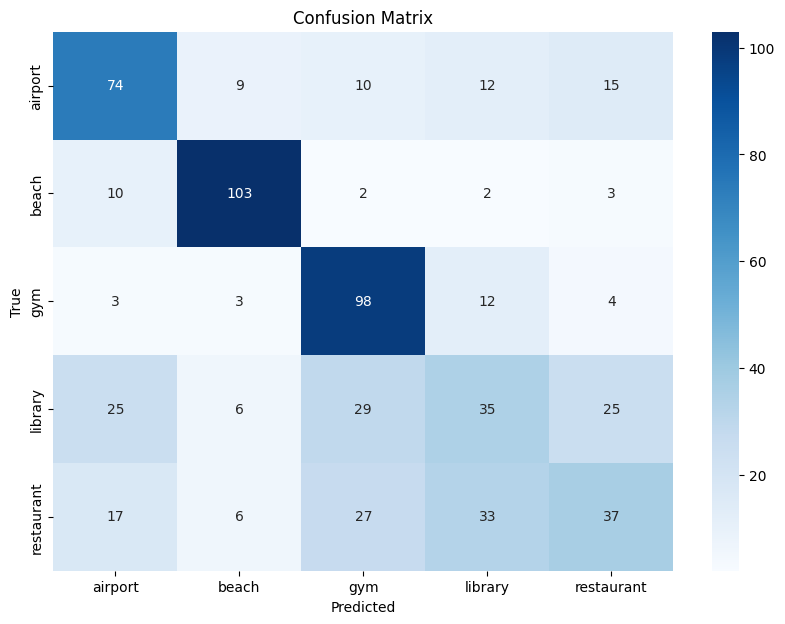

In [ ]:
# Updated evaluation function with additional metrics and confusion matrix
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            y_true.extend(labels.numpy())
            y_pred.extend(preds.numpy())

    # Calculate and print performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('\nClassification Report:\n', classification_report(y_true, y_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load the saved model for evaluation
model_load_path = '/content/drive/MyDrive/dataset/venue_cnn.pth'
model.load_state_dict(torch.load(model_load_path))
evaluate_model(model, test_loader)

# CNN Model-2

Epoch 1/25, Loss: 1.4100, Val Loss: 1.3290, Val Acc: 0.3812
Epoch 2/25, Loss: 1.3036, Val Loss: 1.2766, Val Acc: 0.4167
Epoch 3/25, Loss: 1.2568, Val Loss: 1.2385, Val Acc: 0.4479
Epoch 4/25, Loss: 1.2106, Val Loss: 1.2643, Val Acc: 0.4396
Epoch 5/25, Loss: 1.1677, Val Loss: 1.1921, Val Acc: 0.4938
Epoch 6/25, Loss: 1.0956, Val Loss: 1.1785, Val Acc: 0.4958
Epoch 7/25, Loss: 1.0560, Val Loss: 1.1314, Val Acc: 0.4917
Epoch 8/25, Loss: 1.0211, Val Loss: 1.2131, Val Acc: 0.4958
Epoch 9/25, Loss: 0.9636, Val Loss: 1.2736, Val Acc: 0.5062
Epoch 10/25, Loss: 0.9275, Val Loss: 1.0548, Val Acc: 0.5604
Epoch 11/25, Loss: 0.8544, Val Loss: 1.1529, Val Acc: 0.5563
Epoch 12/25, Loss: 0.7714, Val Loss: 1.0984, Val Acc: 0.5687
Epoch 13/25, Loss: 0.7214, Val Loss: 1.1093, Val Acc: 0.5854
Epoch 14/25, Loss: 0.6936, Val Loss: 1.0786, Val Acc: 0.6188
Epoch 15/25, Loss: 0.6381, Val Loss: 1.0993, Val Acc: 0.6083
Epoch 16/25, Loss: 0.5523, Val Loss: 1.1728, Val Acc: 0.6146
Epoch 17/25, Loss: 0.5364, Val Lo

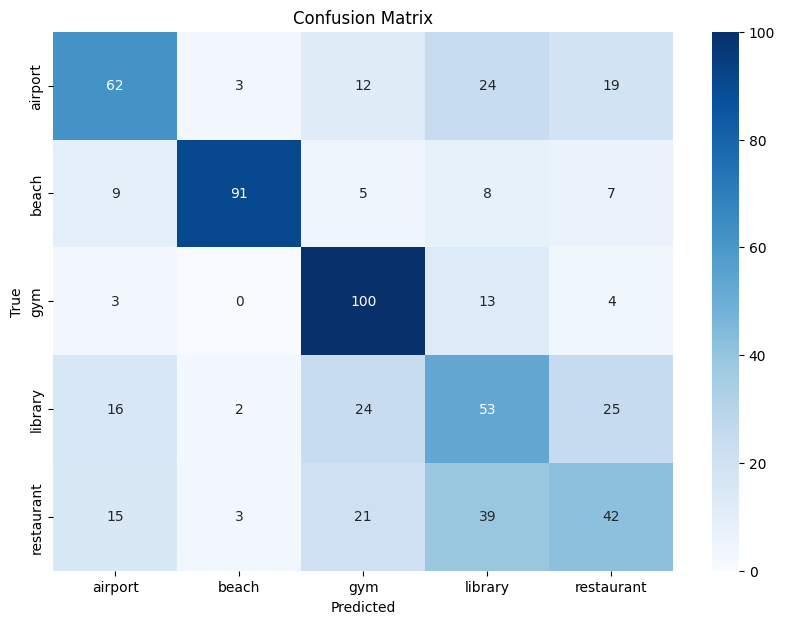

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class VenueCNN_Modified(nn.Module):
    def __init__(self):
        super(VenueCNN_Modified, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 1 input channel for grayscale
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Added an extra convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjusted for extra conv layer
        self.fc2 = nn.Linear(512, 256)  # Added an additional fully connected layer
        self.fc3 = nn.Linear(256, 5)  # Assuming 5 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))  # Added extra conv layer and pooling layer
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  # Added an additional fully connected layer
        x = self.fc3(x)
        return x

# Create model instance
model = VenueCNN_Modified()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function (unchanged)
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = torch.max(outputs, 1)[1]
                corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = corrects.double() / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}', flush=True)

    return model

# Evaluation function (unchanged)
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            y_true.extend(labels.numpy())
            y_pred.extend(preds.numpy())

    # Calculate and print performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('\nClassification Report:\n', classification_report(y_true, y_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load datasets and dataloaders as before (unchanged)
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/validation', transform=val_test_transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/test', transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train and save the model
model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25)
model_save_path = '/content/drive/MyDrive/dataset/venue_cnn_modified.pth'
torch.save(model.state_dict(), model_save_path)

# Load the saved model for evaluation
model_load_path = '/content/drive/MyDrive/dataset/venue_cnn_modified.pth'
model.load_state_dict(torch.load(model_load_path))
evaluate_model(model, test_loader)




# CNN Model-3

Epoch 1/25, Loss: 1.8094, Val Loss: 1.3229, Val Acc: 0.3812
Epoch 2/25, Loss: 1.3435, Val Loss: 1.2359, Val Acc: 0.4500
Epoch 3/25, Loss: 1.3028, Val Loss: 1.2892, Val Acc: 0.3979
Epoch 4/25, Loss: 1.2781, Val Loss: 1.2875, Val Acc: 0.3875
Epoch 5/25, Loss: 1.2813, Val Loss: 1.2192, Val Acc: 0.4396
Epoch 6/25, Loss: 1.2442, Val Loss: 1.2107, Val Acc: 0.4750
Epoch 7/25, Loss: 1.2310, Val Loss: 1.2040, Val Acc: 0.4604
Epoch 8/25, Loss: 1.2090, Val Loss: 1.2206, Val Acc: 0.4313
Epoch 9/25, Loss: 1.2005, Val Loss: 1.1389, Val Acc: 0.4979
Epoch 10/25, Loss: 1.1979, Val Loss: 1.1392, Val Acc: 0.4646
Epoch 11/25, Loss: 1.1547, Val Loss: 1.1498, Val Acc: 0.5083
Epoch 12/25, Loss: 1.1564, Val Loss: 1.2770, Val Acc: 0.4625
Epoch 13/25, Loss: 1.1524, Val Loss: 1.1690, Val Acc: 0.5229
Epoch 14/25, Loss: 1.1377, Val Loss: 1.0930, Val Acc: 0.5625
Epoch 15/25, Loss: 1.0977, Val Loss: 1.0994, Val Acc: 0.5354
Epoch 16/25, Loss: 1.1229, Val Loss: 1.0910, Val Acc: 0.5208
Epoch 17/25, Loss: 1.0524, Val Lo

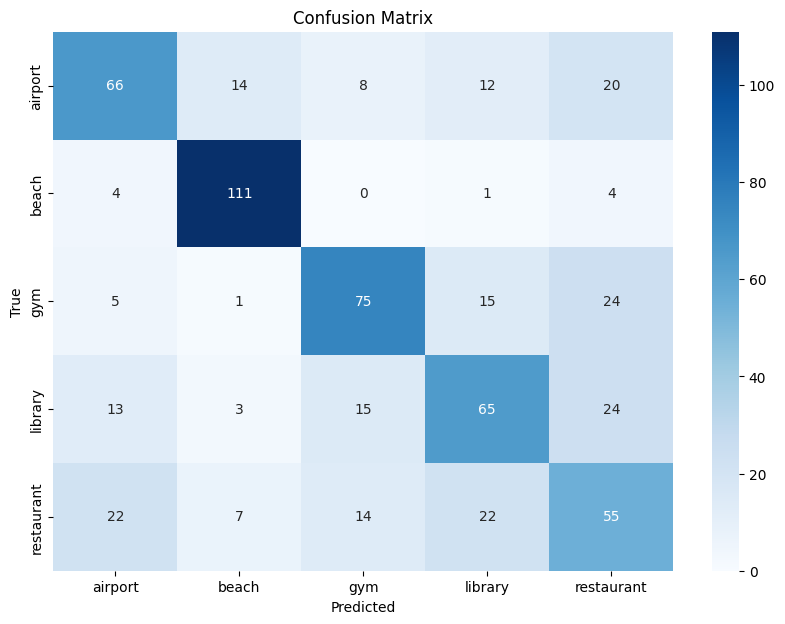

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the further modified CNN model with additional layers and batch normalization
class VenueCNN_Modified(nn.Module):
    def __init__(self):
        super(VenueCNN_Modified, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # Added another conv layer
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Adjusted for extra conv layer
        self.fc2 = nn.Linear(512, 256)  # Additional fully connected layer
        self.fc3 = nn.Linear(256, 5)  # Assuming 5 classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Added conv layer with batch normalization
        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc2(x))  # Additional fully connected layer
        x = self.fc3(x)
        return x

# Create model instance
model = VenueCNN_Modified()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = torch.max(outputs, 1)[1]
                corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = corrects.double() / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}', flush=True)

    return model

# Updated evaluation function with additional metrics and confusion matrix
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            y_true.extend(labels.numpy())
            y_pred.extend(preds.numpy())

    # Calculate and print performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('\nClassification Report:\n', classification_report(y_true, y_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Train and save the model
model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25)
model_save_path = '/content/drive/MyDrive/dataset/venue_cnn_modified2.pth'
torch.save(model.state_dict(), model_save_path)

# Load the saved model for evaluation
model_load_path = '/content/drive/MyDrive/dataset/venue_cnn_modified2.pth'
model.load_state_dict(torch.load(model_load_path))
evaluate_model(model, test_loader)

# Predictions on new Image

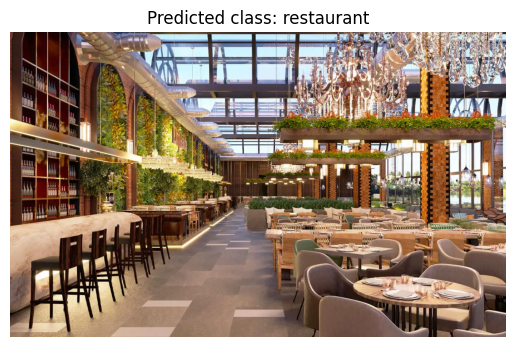

In [ ]:
import torch
from torchvision import transforms, datasets
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the model architecture (necessary to load the model)
class VenueCNN_Modified(nn.Module):
    def __init__(self):
        super(VenueCNN_Modified, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 1 input channel for grayscale
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Added an extra convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjusted for extra conv layer
        self.fc2 = nn.Linear(512, 256)  # Added an additional fully connected layer
        self.fc3 = nn.Linear(256, 5)  # Assuming 5 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))  # Added extra conv layer and pooling layer
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  # Added an additional fully connected layer
        x = self.fc3(x)
        return x

# Define the transformations
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Load the saved model
model_load_path = '/content/drive/MyDrive/dataset/venue_cnn_modified.pth'
model = VenueCNN_Modified()
model.load_state_dict(torch.load(model_load_path))
model.eval()  # Set the model to evaluation mode

# Function to predict the class of a new image
def predict_image(image_path, model, transform):
    image = Image.open(image_path)
    transformed_image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
    with torch.no_grad():
        output = model(transformed_image)
        _, predicted = torch.max(output, 1)
    return predicted.item(), image

# Example usage
new_image_path = '/content/c4bp49g_restaurant-generic_625x300_21_November_23.webp'  # Path to the new image
predicted_class, original_image = predict_image(new_image_path, model, val_test_transform)

# Load datasets to get the class names
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/train', transform=val_test_transform)
class_names = train_dataset.classes
predicted_class_name = class_names[predicted_class]

# Display the image with its predicted class
plt.imshow(original_image)
plt.title(f'Predicted class: {predicted_class_name}')
plt.axis('off')
plt.show()
